<a href="https://colab.research.google.com/github/yaniv256/VAEs-in-Economics/blob/master/Notebooks/Movie_reviews_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

In [0]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [3]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[1]])

decoded_review

"? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        uniques, counts = np.unique(sequence, return_counts=True)
        results[i, uniques] = counts/np.sum(counts)  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [5]:
x_train[0]

array([0.        , 0.00458716, 0.02752294, ..., 0.        , 0.        ,
       0.        ])

We should also vectorize our labels, which is straightforward:

In [0]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Now our data is ready to be fed into a neural network.

In [0]:
#!rm -f vaes_net.py
#!wget "https://raw.githubusercontent.com/yaniv256/VAEs-in-Economics/master/Notebooks/vaes_net.py"

In [0]:

import vaes_net as vnn
import importlib

In [9]:
import pandas as pd

data = pd.DataFrame(np.concatenate([x_train,x_test],axis=0))

labels = [reverse_word_index.get(i - 3, '?') for i in range(0,10000)]
labels[0]="not used"
labels[1]="padding"
labels[2]="start of sequence"
labels[3]="unknown"

data.columns = labels

data

,not used,padding,start of sequence,unknown,the,and,a,of,to,is,br,in,it,i,this,that,was,as,for,with,movie,but,film,on,not,you,are,his,have,he,be,one,all,at,by,an,they,who,so,from,...,ounce,bagdad,stud,closeups,insisted,jed,geeky,64,aims,complains,ewan,exhausted,day's,weaves,gladly,misogynistic,soles,michel,uniquely,interminable,aristocrat,paul's,everybody's,avant,answering,smallest,contacts,enlightenment,murphy's,employs,unforgivable,punchline,culminating,talentless,grabbing,soulless,unfairly,grail,retrospect,edged
0,0.0,0.004587,0.027523,0.0,0.068807,0.041284,0.013761,0.009174,0.013761,0.004587,0.000000,0.000000,0.027523,0.013761,0.013761,0.018349,0.050459,0.013761,0.013761,0.009174,0.000000,0.004587,0.027523,0.000000,0.000000,0.018349,0.013761,0.000000,0.009174,0.000000,0.004587,0.000000,0.013761,0.009174,0.000000,0.004587,0.018349,0.000000,0.018349,0.004587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.005291,0.037037,0.0,0.079365,0.052910,0.015873,0.010582,0.015873,0.052910,0.000000,0.010582,0.000000,0.005291,0.015873,0.021164,0.010582,0.000000,0.005291,0.005291,0.005291,0.005291,0.005291,0.010582,0.000000,0.000000,0.010582,0.000000,0.005291,0.005291,0.005291,0.000000,0.005291,0.005291,0.000000,0.005291,0.000000,0.005291,0.005291,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.007092,0.014184,0.0,0.063830,0.000000,0.028369,0.028369,0.028369,0.014184,0.000000,0.014184,0.028369,0.014184,0.028369,0.007092,0.014184,0.000000,0.007092,0.007092,0.000000,0.007092,0.028369,0.021277,0.000000,0.000000,0.000000,0.000000,0.007092,0.000000,0.007092,0.014184,0.000000,0.014184,0.000000,0.014184,0.014184,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.001818,0.092727,0.0,0.065455,0.021818,0.014545,0.038182,0.021818,0.021818,0.029091,0.021818,0.014545,0.009091,0.009091,0.009091,0.001818,0.009091,0.000000,0.010909,0.000000,0.007273,0.003636,0.007273,0.000000,0.009091,0.001818,0.012727,0.000000,0.010909,0.005455,0.007273,0.001818,0.001818,0.000000,0.005455,0.003636,0.001818,0.003636,0.003636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.006803,0.006803,0.0,0.013605,0.040816,0.013605,0.027211,0.013605,0.000000,0.013605,0.013605,0.020408,0.061224,0.013605,0.020408,0.013605,0.000000,0.020408,0.006803,0.020408,0.000000,0.006803,0.000000,0.000000,0.013605,0.000000,0.000000,0.006803,0.000000,0.000000,0.000000,0.006803,0.006803,0.000000,0.006803,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.001805,0.048736,0.0,0.072202,0.021661,0.012635,0.050542,0.014440,0.023466,0.000000,0.028881,0.010830,0.010830,0.023466,0.009025,0.001805,0.005415,0.014440,0.003610,0.005415,0.009025,0.021661,0.003610,0.009025,0.001805,0.005415,0.005415,0.001805,0.001805,0.007220,0.001805,0.005415,0.001805,0.001805,0.001805,0.000000,0.005415,0.005415,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,0.0,0.013889,0.055556,0.0,0.083333,0.013889,0

In [0]:
from sklearn.preprocessing import QuantileTransformer

qt_trans = QuantileTransformer(n_quantiles=1000, random_state=2)
qt_trans.fit(data[:1000])
qt = pd.DataFrame(qt_trans.transform(data))
qt.columns = labels

x_train = qt[:25000]
x_test = qt[25000:]

In [11]:
x_train

,not used,padding,start of sequence,unknown,the,and,a,of,to,is,br,in,it,i,this,that,was,as,for,with,movie,but,film,on,not,you,are,his,have,he,be,one,all,at,by,an,they,who,so,from,...,ounce,bagdad,stud,closeups,insisted,jed,geeky,64,aims,complains,ewan,exhausted,day's,weaves,gladly,misogynistic,soles,michel,uniquely,interminable,aristocrat,paul's,everybody's,avant,answering,smallest,contacts,enlightenment,murphy's,employs,unforgivable,punchline,culminating,talentless,grabbing,soulless,unfairly,grail,retrospect,edged
0,0.0,0.380881,0.244244,0.0,0.758759,0.866867,0.141642,0.132132,0.237237,0.128629,0.000000,0.000000,0.844845,0.579580,0.535035,0.798799,0.988989,0.805806,0.840340,0.713714,0.000000,0.367868,0.960961,0.000000,0.000000,0.909910,0.912913,0.000000,0.817818,0.000000,0.554054,0.000000,0.922923,0.862362,0.000000,0.673674,0.982983,0.000000,0.978979,0.671672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.473974,0.365866,0.0,0.879880,0.960961,0.202202,0.148649,0.295796,0.982983,0.000000,0.341341,0.000000,0.314314,0.620120,0.862362,0.674675,0.000000,0.418919,0.457958,0.511011,0.406406,0.546547,0.811812,0.000000,0.000000,0.853353,0.000000,0.635636,0.722723,0.600601,0.000000,0.656156,0.677678,0.000000,0.715716,0.000000,0.736737,0.723724,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.676176,0.091592,0.0,0.680681,0.000000,0.568569,0.692192,0.734735,0.427427,0.000000,0.489990,0.859860,0.589089,0.883884,0.350350,0.754254,0.000000,0.537037,0.591592,0.000000,0.532533,0.965966,0.974975,0.000000,0.000000,0.000000,0.000000,0.729730,0.000000,0.728228,0.931932,0.000000,0.954955,0.000000,0.962963,0.949950,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.080080,0.879880,0.0,0.711712,0.355355,0.166166,0.881882,0.500501,0.678679,0.792793,0.777778,0.595596,0.460460,0.342843,0.456957,0.361361,0.675676,0.000000,0.777778,0.000000,0.544545,0.490490,0.661662,0.000000,0.744244,0.472472,0.893894,0.000000,0.885886,0.609610,0.748749,0.490490,0.497497,0.000000,0.721722,0.666667,0.577578,0.627628,0.615616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.647147,0.049049,0.0,0.019019,0.858358,0.135135,0.655656,0.230731,0.000000,0.551552,0.461461,0.740741,0.983984,0.528529,0.847848,0.739740,0.000000,0.946446,0.571572,0.846847,0.000000,0.612112,0.000000,0.000000,0.843343,0.000000,0.000000,0.711211,0.000000,0.000000,0.000000,0.740741,0.759760,0.000000,0.805806,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.0,0.501502,0.317317,0.0,0.803430,0.540541,0.372873,0.469469,0.714214,0.688689,0.000000,0.897898,0.657157,0.000000,0.176842,0.541040,0.000000,0.873373,0.740240,0.785786,0.686877,0.422923,0.000000,0.545744,0.000000,0.797798,0.000000,0.000000,0.649149,0.735736,0.617618,0.000000,0.671672,0.688188,0.727728,0.000000,0.913914,0.000000,0.000000,0.731732,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24996,0.0,0.209710,0.322777,0.0,0.421922,0.089838,0

In [0]:
train_examples = x_train.shape[0]
flag_0 = np.zeros((train_examples,1),dtype=x_train.values.dtype)
x_train = np.concatenate((x_train.values,flag_0),axis=-1)
test_examples = x_test.shape[0]
flag_1 = np.ones((test_examples,1),dtype=x_test.values.dtype)
x_test = np.concatenate((x_test.values,flag_1),axis=-1)

In [22]:
from tensorflow import set_random_seed
from numpy.random import seed

importlib.reload(vnn)
seed(42)
set_random_seed(42)

vae = vnn.make_vae(full_data=qt,  
    img_shape = (10000+1, ),
    latent_dim = 1, 
    dense_width = 2045,
    l2_penalty=0.000000000001,
    l1_penalty=0.0,
    encoder_dropout_rate=0.5,
    decoder_dropout_rate=0.001,
    entanglement_penalty = 2,
    hidden_n = 2,
    initial_lr = 0.1,
    plot_types_args = {'n_type': 60, 'each_hight' : 20, 
                                  'approx_width': 400, 
                                  'frac_width': 0.55, 
                                  'n_activity':  200,  
                                  'lowest_percentile': 1, 
                                  'highest_percentile' : 99, 
                                  'figsize': (10, 81),
                                  'cmap': 'viridis', 
                                  'n_xlabels':13, 
                                  'spacing': -0.005, 
                                  'hist_size': 0.08, 
                                  'scaler': True})  


(?, 1)


In [0]:
epochs = 50
batch_size = 512

In [25]:
n_starts = 1

for i in range(0,n_starts):

  print("Round number: ", i+1)

  fitted = vae.fit(
      x=x_train, 
      y=None,
      shuffle=True,
      epochs=round(epochs/n_starts),
      batch_size=batch_size,
      validation_data=(x_test, None),
      callbacks = vae.callback_list
      )

Round number:  1
Train on 25000 samples, validate on 25000 samples
Epoch 1/50
24576/25000 [============================>.] - ETA: 0s - loss: nan

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:433: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):


ValueError: ignored

/usr/local/lib/python3.6/dist-packages/matplotlib/ticker.py:696: RuntimeWarning: invalid value encountered in less_equal
  locs = locs[(vmin <= locs) & (locs <= vmax)]
/usr/local/lib/python3.6/dist-packages/matplotlib/ticker.py:744: RuntimeWarning: invalid value encountered in less_equal
  locs = locs[(vmin <= locs) & (locs <= vmax)]


ValueError: ignored

<Figure size 720x5832 with 4 Axes>

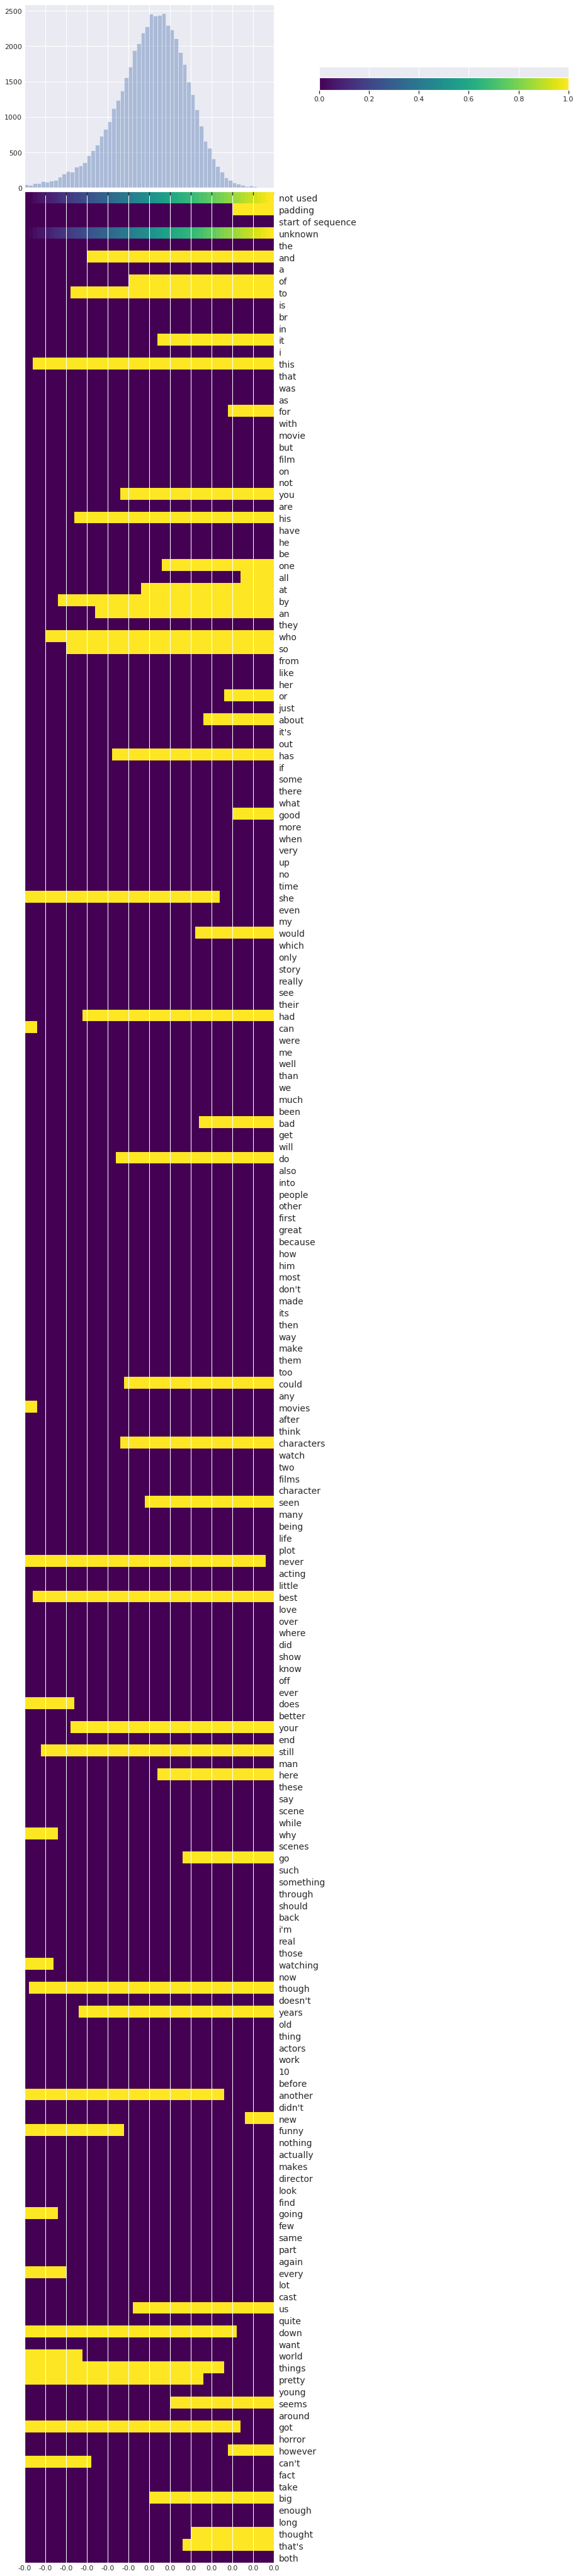

In [16]:

vnn.plot_types(encoder=vae.encoder,decoder=vae.decoder,data=qt,
           n_activity=  200,  
           lowest_percentile=0.5, 
           highest_percentile=99.5, 
           figsize =(10, 81), 
           hist_size=0.05, spacing= -0.001);